In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
data = np.load("data/DK_time_series_3000000.npy")

train = data[:-500000]
test =  data[-500000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [3]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [21]:
def one_hot(x, num_channels=256, device='cuda'):
    x_o = torch.FloatTensor(x.shape[0], num_channels, x.shape[1])
    x_o = x_o.to(device)
    x_o.zero_().scatter_(1, x.unsqueeze(1), 1)
    return x_o

In [5]:
int_data = amp_to_int(data)
train = int_data[:-500000]
test = int_data[-500000:]

In [89]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train, train_window)
test_inout_seq = create_inout_sequences(test, train_window)

In [90]:
train_inout_seq[0][0]

array([ 86., 193.,  35.,  84.,   0.,  30.,  66., 215.,  49.,  47., 106.,
       218.,  31.,  63., 166., 100.,  37.,  71., 199.,  55.])

In [91]:
for i in range(len(train_inout_seq)):
    if len(train_inout_seq[i][0]) != 20:
        print(i)

In [16]:
train_inout_seq[0][0].reshape(1, 20, 1)

array([[[ 86.],
        [193.],
        [ 35.],
        [ 84.],
        [  0.],
        [ 30.],
        [ 66.],
        [215.],
        [ 49.],
        [ 47.],
        [106.],
        [218.],
        [ 31.],
        [ 63.],
        [166.],
        [100.],
        [ 37.],
        [ 71.],
        [199.],
        [ 55.]]])

In [33]:
train_inout_seq[0:2]

[(array([ 86., 193.,  35.,  84.,   0.,  30.,  66., 215.,  49.,  47., 106.,
         218.,  31.,  63., 166., 100.,  37.,  71., 199.,  55.]),
  array([37.])),
 (array([193.,  35.,  84.,   0.,  30.,  66., 215.,  49.,  47., 106., 218.,
          31.,  63., 166., 100.,  37.,  71., 199.,  55.,  37.]),
  array([68.]))]

In [40]:
one_hot(torch.LongTensor(train_inout_seq[0][0]).reshape((1, 20)), device='cpu').argmax(axis=1)

tensor([[ 86, 193,  35,  84,   0,  30,  66, 215,  49,  47, 106, 218,  31,  63,
         166, 100,  37,  71, 199,  55]])

In [52]:
train_inout_seq[0][0].dtype = 'int'

In [92]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

In [97]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=256, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]
        #assert batchsize == 64

        # layer 1
        x = self.linear_1(x)
        
        #assert x.size() == torch.Size((64, 20, 256))
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2) 
        
        x = torch.nn.Flatten()(x)
        
        #assert x.size() == torch.Size((64, 512))
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        
        #assert predictions.size() == torch.Size((64, 256)) 
        return predictions

In [98]:
model_lstm = LSTMModel(input_size=256, hidden_layer_size=256, num_layers=2, output_size=256, dropout=0.2)
model_lstm = model_lstm.to('cuda')

In [99]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]
        
        
        
        x = x.type(torch.LongTensor)
        
        

        x = torch.reshape(x, (64, 20)).to('cuda')
        x_o = one_hot(x)
        
        y = y.type(torch.LongTensor)
        y = y.view(-1).to('cuda')
        
        #print(x_o.size())

        out = model(x_o.permute(0, 2, 1))
        loss = criterion(out, y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

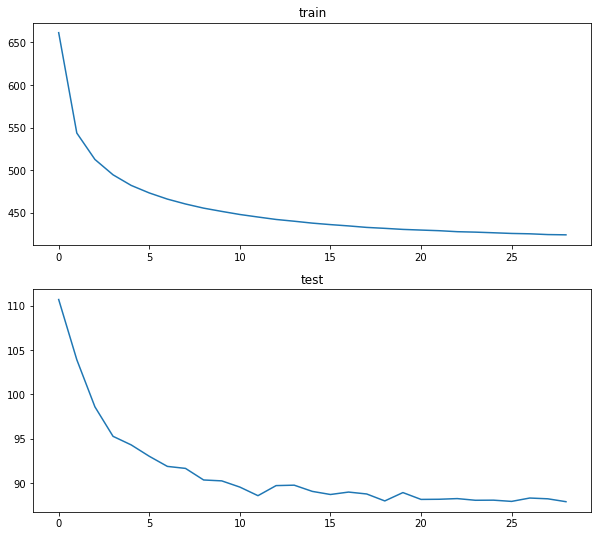

 17%|████████████▌                                                               | 29/175 [1:43:55<8:29:11, 209.25s/it]

Epoch[29/175] | loss train:424.209704, test:87.915437


In [ ]:
# define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
best_loss = 10e9
# begin training
for epoch in tqdm(range(epochs)): 
    if epoch > 40:
        lr = 0.0005
    if epoch > 100:
        lr = 0.0001
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(model_lstm.state_dict(), "./LSTMLargeDataBin")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

## Transformer

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
    
        return x + self.pe[:x.size(0), :]
          

class TransAm(nn.Module):
    def __init__(self,feature_size=250, nhead=10, num_layers=2,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        #print(src.size())
        src = self.pos_encoder(src)
        #print(src.size())

        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        #print(output.size())
        
        output = self.decoder(output)
        #print(output.size())
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [ ]:
model_trans = TransAm().to('cuda')

In [ ]:
input_window = 20
batch_size = 64

In [ ]:
def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

In [ ]:
def run_epoch(model, train_data, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        if is_training:
            optimizer.zero_grad()
            
        #print(x.size())
        #print(y.size())
        #x = torch.transpose(x, 0, 1).reshape((20, 10, 1)).float().to('cuda')
        #y = y.view(-1).float().to('cuda')
        
        data = data.type(torch.LongTensor)
        data = torch.reshape(data, (64, 20)).to('cuda')
        x_o = one_hot(x)
        
        targets = targets.type(torch.LongTensor)
        targets = targets.view(-1).to('cuda')

        out = model(data.to('cuda'))
        loss = criterion(out, targets)

        if is_training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

        epoch_loss += (loss.detach().item() / batch_size)

    #lr = scheduler.get_last_lr()[0]

    return epoch_loss

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.005 
optimizer = optim.Adam(model_trans.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer,  1.0, gamma=0.95)

losses_train = []
losses_test = []
best_loss = 1e9
# begin training
for epoch in range(200):
    loss_train = run_epoch(model_trans, train_inout_seq, is_training=True)
    loss_val = run_epoch(model_trans, test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(model_trans.state_dict(), "./TransformerLargeBin")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val))